# Test Notebook

**Simple Execution** is the first test, where I manually instantiate all the necessary classes and perform a non-automatic computation.

**Multi-Round Execution** is the automatic computation of the algorithm.

In [34]:
import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


## Simple Execution

In [ ]:
w1 = Worker(coef = np.array([0, 0]), intercept = np.array([0]), model=linear_model.LinearRegression())
w2 = Worker(coef = np.array([0, 0]), intercept = np.array([0]), model=linear_model.LinearRegression())
w3 = Worker(coef = np.array([0, 0]), intercept = np.array([0]), model=linear_model.LinearRegression())

In [ ]:
l = []
l.append(w1)
l.append(w2)
l.append(w3)

In [ ]:
dataset_X, dataset_y = datasets.load_diabetes(return_X_y=True)

In [ ]:
server = Server(coef = np.array([0, 0]), intercept = np.array([0]), workers = l, num_features = dataset_X[0].size)

In [ ]:
train_w1_X, train_w2_X, train_w3_X, test_X = np.split(dataset_X, 
                                                      [int(.25 * len(dataset_X)), 
                                                       int(.50 * len(dataset_X)), 
                                                       int(.75 * len(dataset_X))
                                                      ])

In [ ]:
train_w1_y, train_w2_y, train_w3_y, test_y = np.split(dataset_y, 
                                                      [int(.25 * len(dataset_y)), 
                                                       int(.50 * len(dataset_y)), 
                                                       int(.75 * len(dataset_y))
                                                      ])

In [ ]:
train_w1_1, train_w1_2, train_w1_3 = np.split(train_w1_X,  
                                                [int(.33 * len(train_w1_X)), 
                                                int(.66 * len(train_w1_X))
                                                ])

train_w2_1, train_w2_2, train_w2_3 = np.split(train_w2_X,  
                                                [int(.33 * len(train_w2_X)), 
                                                int(.66 * len(train_w2_X))
                                                ])

train_w3_1, train_w3_2, train_w3_3 = np.split(train_w3_X,  
                                                [int(.33 * len(train_w3_X)), 
                                                int(.66 * len(train_w3_X))
                                                ])




train_w1_y_1, train_w1_y_2, train_w1_y_3 = np.split(train_w1_y, 
                                                      [int(.33 * len(train_w1_y)), 
                                                       int(.66 * len(train_w1_y))
                                                      ])

train_w2_y_1, train_w2_y_2, train_w2_y_3 = np.split(train_w2_y, 
                                                      [int(.33 * len(train_w2_y)), 
                                                       int(.66 * len(train_w2_y))
                                                      ])

train_w3_y_1, train_w3_y_2, train_w3_y_3 = np.split(train_w3_y, 
                                                      [int(.33 * len(train_w3_y)), 
                                                       int(.66 * len(train_w3_y))
                                                      ])

In [ ]:
w1.train(X = train_w1_X, y = train_w1_y)
w2.train(X = train_w2_X, y = train_w2_y)
w3.train(X = train_w3_X, y = train_w3_y)


In [ ]:
w3.model.coef_

In [ ]:
server.aggregation()

In [ ]:
print('Server Coef: ', server.coef)
print('Server intercept: ', server.intercept)

In [ ]:
server.return_to_workers()

In [ ]:
w3.coef

In [ ]:
pred_w1 = w1.evaluate(test_X)
print('Mean squared error worker 1: %.2f' 
         % mean_squared_error(test_y, pred_w1))
print('Coefficient of determinaton of worker 1: %.2f'
         % r2_score(test_y, pred_w1))

print('----------')

pred_w2 = w2.evaluate(test_X)
print('Mean squared error worker 2: %.2f' 
         % mean_squared_error(test_y, pred_w2))
print('Coefficient of determinaton of worker 2: %.2f'
         % r2_score(test_y, pred_w2))

print('----------')

pred_w3 = w3.evaluate(test_X)
print('Mean squared error worker 3: %.2f' 
         % mean_squared_error(test_y, pred_w3))
print('Coefficient of determinaton of worker 3: %.2f'
         % r2_score(test_y, pred_w3))

In [ ]:
server.return_to_workers()

In [ ]:
pred_server = server.evaluate(test_X)
print('Mean squared error: %.2f' 
         % mean_squared_error(test_y, pred_server))
print('Coefficient of determinaton: %.2f'
         % r2_score(test_y, pred_server))

# Multi Rounds

In [98]:
num_workers = 4
num_rounds = 20

m = 2.3
c = 1.6

In [99]:
dataset_X = np.linspace(0, 10, 1000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(20)

dataset_X = dataset_X.reshape(-1,1)

In [100]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [101]:
train_percentage = 0.8


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [102]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [103]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [104]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))
    

Intercept: -0.2601626113002915
Intercept: 0.8464996837404808
Intercept: 0.04667807868410456
Intercept: -5.767475837883303
Sum: [-1.28361517]
------ROUND 1------
Mean squared error: 21.284
Coefficient of determinaton: 0.680 

Intercept: -1.8566439453656134
Intercept: -1.2026875124100584
Intercept: -2.6816713372988
Intercept: 5.767573459724619
Sum: [0.00664267]
------ROUND 2------
Mean squared error: 20.449
Coefficient of determinaton: 0.692 

Intercept: 7.629277205566373
Intercept: 1.9113416542770736
Intercept: -1.5164613288312871
Intercept: 0.1288237203955127
Sum: [2.03824531]
------ROUND 3------
Mean squared error: 20.014
Coefficient of determinaton: 0.699 

Intercept: 5.332245124587202
Intercept: 1.8576894483766342
Intercept: 2.8778680936305783
Intercept: 2.0808598467686696
Sum: [3.03716563]
------ROUND 4------
Mean squared error: 19.491
Coefficient of determinaton: 0.707 

Intercept: 4.963772035320854
Intercept: -0.20656488902465497
Intercept: 0.08188986473268933
Intercept: 4.279154

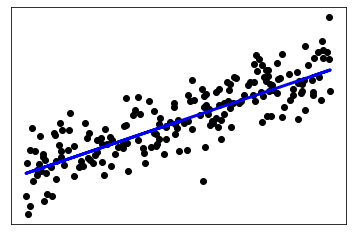

In [105]:
plt.scatter(test_X, test_y,  color='black')
plt.plot(test_X, pred_server, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

<Figure size 720x360 with 0 Axes>

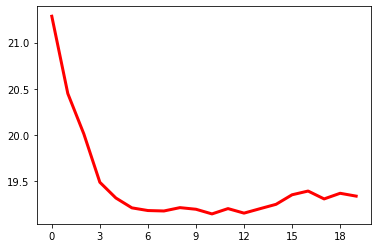

In [112]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)

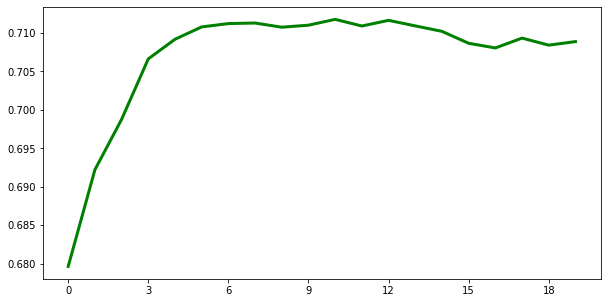

In [114]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.draw()